In [31]:
import pandas as pd
import xml.etree.ElementTree as etree
from datetime import datetime as dt

In [4]:
def get_grant_basics(root):
    aw_id = root[0].findtext('AwardID')
    amnt = root[0].findtext('AwardAmount')
    beg_dt = root[0].findtext('AwardEffectiveDate')
    end_dt = root[0].findtext('AwardExpirationDate')
    return int(aw_id), int(amnt), beg_dt, end_dt

def delta_2_YM(td):
    resYr = float(td.days)/364.0                   
    resMo = int((resYr - int(resYr))*364/30)  
    resYr = int(resYr)
    return (resYr, resMo)

def get_yr_len(st_dt, en_dt):
    beg = dt.strptime(st_dt, '%m/%d/%Y')
    end = dt.strptime(en_dt, '%m/%d/%Y')
    return delta_2_YM(end-beg)

def get_length(st_dt, en_dt):
    beg = dt.strptime(st_dt, '%m/%d/%Y')
    end = dt.strptime(en_dt, '%m/%d/%Y')
    return end-beg

def get_PIs(root):
    inv= root[0].findall('Investigator')
    inv_ls = []
#     for c in inv:
    if len(inv)>0:
        for i in inv[0]:
            inv_ls +=[i.text]
    else:
        inv_ls = [None, None, None, None, None, None ]
    return inv_ls

def get_inst_info(root):
    ins= root[0].find('Institution')
    ins_ls = []
    for c in ins:
        ins_ls += [c.text]
    return ins_ls

def get_field_info(root):
    foa= root[0].find('FoaInformation')
    if foa == None:
        foa = root[0].find('ProgramElement')
    foa_ls =[]
    if foa != None:
        for c in foa:
            foa_ls += [c.text]
    else: 
        foa_ls = [None, None]
    return foa_ls

def get_grant_info(root):
    ls = []
    ls = list(get_grant_basics(root))
    delta = get_length(ls[-2], ls[-1])
    ls += [delta.days]
    ls += get_PIs(root)
    ls += get_inst_info(root)
    ls += get_field_info(root)
    return ls

In [5]:
cols = ['AwardID','AwardAmount','AwardEffectiveDate','AwardExpirationDate', 'AwardLength',\
        'FirstName','LastName','EmailAddress','StartDate','EndDate','RoleCode',\
        'InstName','CityNam','ZipCode','PhoneNumber','StreetAddress','CountryName','StateName','StateCode',\
        'field_code', 'field_name']

In [6]:
grants_df = pd.DataFrame(columns=cols)

In [7]:
'''1) Convert XML to Pandas DF'''
import glob
i = 0
for filename in glob.glob('dataset/2008/*.xml'):
    tree = etree.parse(filename)
    root = tree.getroot()
    l = get_grant_info(root)
    grants_df.loc[i] = l
    i +=1   

In [10]:
grants_df.shape

(12614, 21)

In [444]:
'''2) Extract Gender from First name, using gender API'''
import json
import urllib2

myKey = "VauASxTHcnYsCyVDxK"

def get_gender(Q_name):
    data = json.load(urllib2.urlopen("https://gender-api.com/get?key=" + myKey + "&name="+Q_name))
    return data["gender"]

In [445]:
grants_df['ga_gender'] = grants_df['FirstName'].apply(lambda l: get_gender(l))

In [18]:
grants_df.drop_duplicates(inplace=True)

In [36]:
%pylab inline
import seaborn as sns
sns.set(context='notebook', style='white', palette='deep', font='sans-serif',\
        font_scale=1.5, color_codes=False, rc=None)

Populating the interactive namespace from numpy and matplotlib


# 1) Is duration and grant amount correlated? 

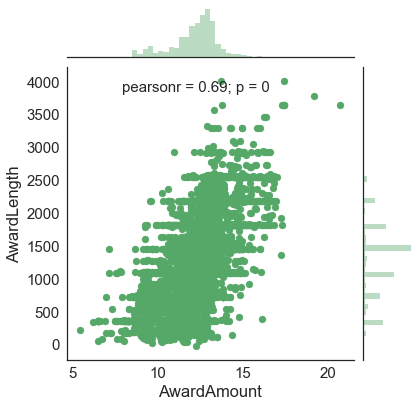

In [37]:
filter = grants_df['AwardAmount']>100
amount_len = grants_df[filter][['AwardAmount', 'AwardLength']].dropna()

g = sns.jointplot(amount_len['AwardAmount'].apply(lambda l: log(l)), amount_len['AwardLength'], color='g')

# 2) Distribution by state, only top 40 states

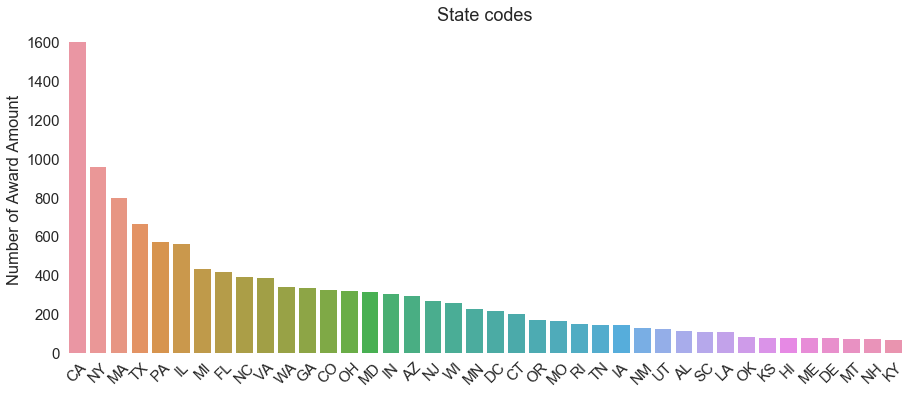

In [38]:
figure(figsize=(15,6))
'''
groupby.sum() adds all different occurances of each country
Then we sort by the number of scientists who have migrated.
'''
grants_df['AwardAmount'] = grants_df['AwardAmount'].astype(float)
grants_df['Counts'] = 1
tot_cnt = grants_df.groupby("StateCode").sum().sort_values(by="Counts", ascending=False).head(40)
tot_cnt["StateCode"] = tot_cnt.index
ax = sns.barplot(x="StateCode", y="Counts", data=tot_cnt)
# ax.set_yscale('log')

plt.xticks(rotation=45)
ax.set_ylabel('Number of Award Amount')
ax.set_xlabel(' ')
ax.set_title('State codes')
ax.grid(0)
ax.set_frame_on(False)

In [24]:
top_stats = tot_cnt[['AwardAmount', 'Counts']].reset_index()['StateCode']

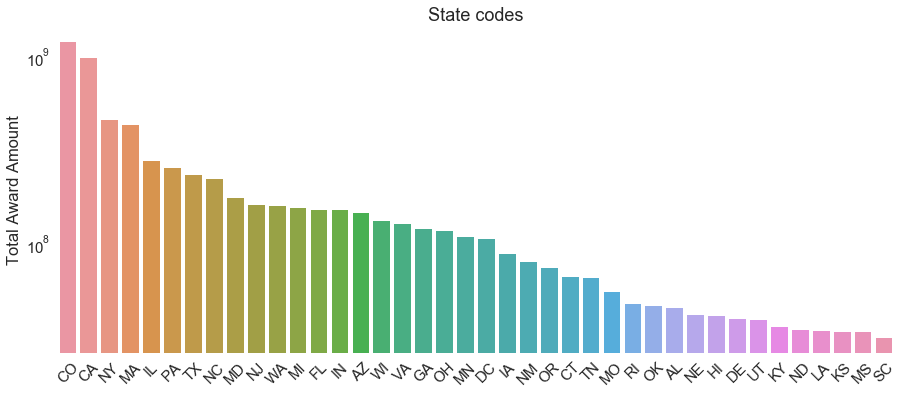

In [39]:
figure(figsize=(15,6))
'''
groupby.sum() adds all different occurances of each country
Then we sort by the number of scientists who have migrated.
'''
most_tot = grants_df.groupby("StateCode").sum().sort_values(by="AwardAmount", ascending=False).head(40)
most_tot["StateCode"] = most_tot.index
ax = sns.barplot(x="StateCode", y="AwardAmount", data=most_tot)
ax.set_yscale('log')

plt.xticks(rotation=45)
ax.set_ylabel('Total Award Amount')
ax.set_xlabel(' ')
ax.set_title('State codes')
ax.grid(0)
ax.set_frame_on(False)

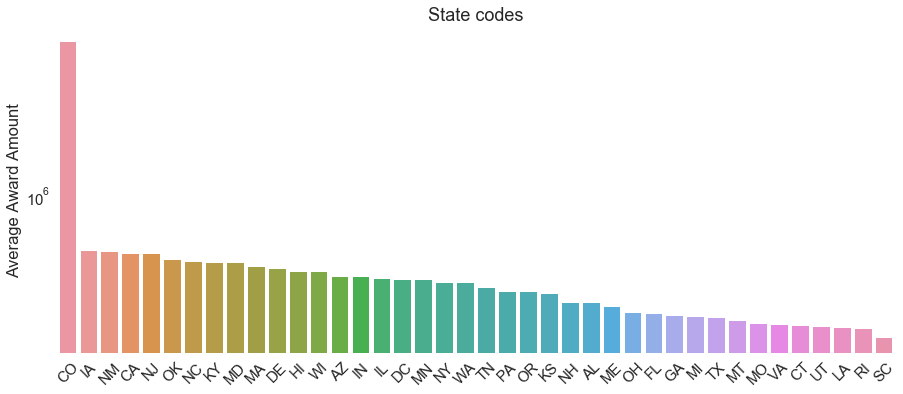

In [40]:
figure(figsize=(15,6))
'''
groupby.sum() adds all different occurances of each country
Then we sort by the number of scientists who have migrated.
'''
filter = grants_df['StateCode'].isin(top_stats)
most = grants_df[filter].groupby("StateCode").mean().sort_values(by="AwardAmount", ascending=False).head(40)
most["StateCode"] = most.index
ax = sns.barplot(x="StateCode", y="AwardAmount", data=most)
ax.set_yscale('log')


plt.xticks(rotation=45)
ax.set_ylabel('Average Award Amount')
ax.set_xlabel(' ')
ax.set_title('State codes')
ax.grid(0)
ax.set_frame_on(False)

In [27]:
# most.sort_values(by=['AwardAmount'], ascending=False).head(5)

In [28]:
# grants_df.head(2)

In [29]:
grpby_gender = {k:list(v) for k,v in grants_df.groupby('ga_gender')['Counts']}
gender_cnt = {k:sum(v) for k,v in grpby_gender.items()}

In [33]:
gender_df = pd.DataFrame(list(gender_cnt.items()), columns=['Gender', 'Counts'])
gender_df['Percent'] = gender_df['Counts'].apply(lambda l: float(l)/sum(gender_df['Counts'])*100)

In [34]:
gender_df = gender_df[gender_df['Gender']!='unknown']

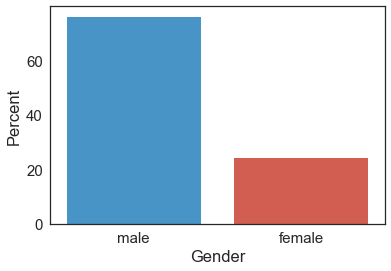

In [41]:
fig = figure(figsize=(6, 4))

color_code = ["#3498db", "#e74c3c"]
ax = fig.gca()
sns.barplot(x='Gender',y='Percent',data=gender_df, palette=sns.color_palette(color_code))
ax.set(ylabel="Percent");
grid(0)

In [42]:
# grants_df.head(2)

In [43]:
grants_df = grants_df[grants_df['ga_gender']!='unknown']

# 3) Gender disparities across different states

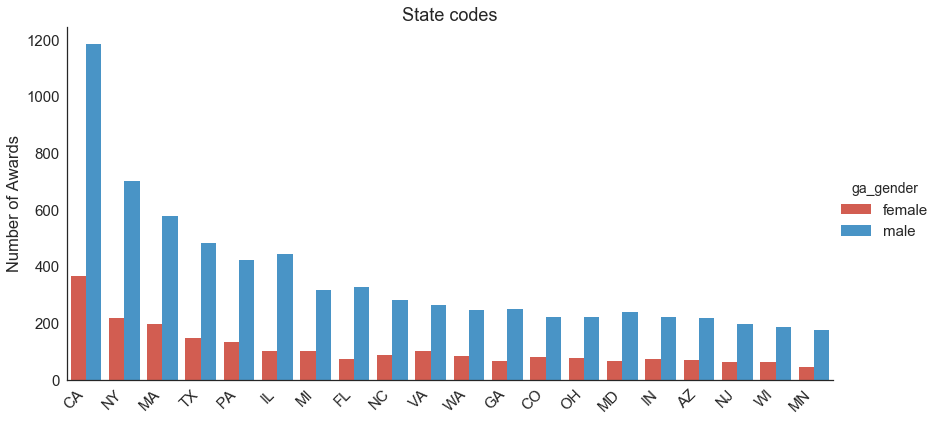

In [58]:
# plot state color coded by __Gender__
color_code = [ "#e74c3c", "#3498db"]
filter = grants_df['StateCode'].isin(top_stats[:20])

plot = sns.factorplot(x='StateCode', y='Counts', hue='ga_gender', kind='bar',\
                      data=grants_df[filter], order=top_stats[:20], palette=sns.color_palette(color_code),\
                      estimator=sum, size=6, aspect=2)
plot.set_xticklabels(rotation=45, horizontalalignment='right');
xlabel(' ')
title('State codes')
ylabel('Number of Awards');
savefig('state_gender_award_number.png', bbox_inches='tight')

In [97]:
top_stats = tot_cnt[['AwardAmount', 'Counts']].reset_index()['StateCode']

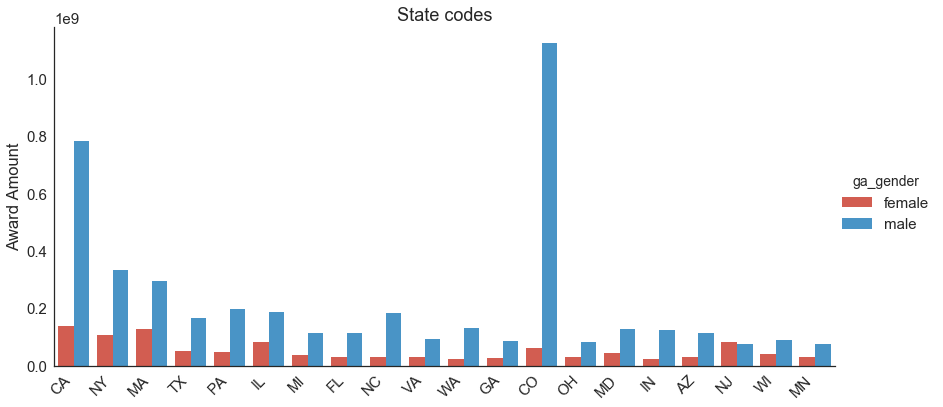

In [55]:
color_code = [ "#e74c3c", "#3498db"]
filter = grants_df['StateCode'].isin(top_stats[:20])

plot = sns.factorplot(x='StateCode', y='AwardAmount', hue='ga_gender', kind='bar',\
                      data=grants_df[filter], order=top_stats[:20], palette=sns.color_palette(color_code),\
                      estimator=sum, size=6, aspect=2, ci=None)
plot.set_xticklabels(rotation=45, horizontalalignment='right');
xlabel(' ')
title('State codes')
ylabel('Award Amount');
savefig('state_gender_award_amount.png', bbox_inches='tight')

# 4) Gender disparities across different disciplines

In [48]:
len(grants_df['field_name'].unique())

330

In [49]:
fld_cnt = grants_df.groupby("field_name").sum().sort_values(by="Counts", ascending=False).head(40)
fld_cnt["field_name"] = fld_cnt.index

In [50]:
top_flds = fld_cnt[['AwardAmount', 'Counts']].reset_index()['field_name']

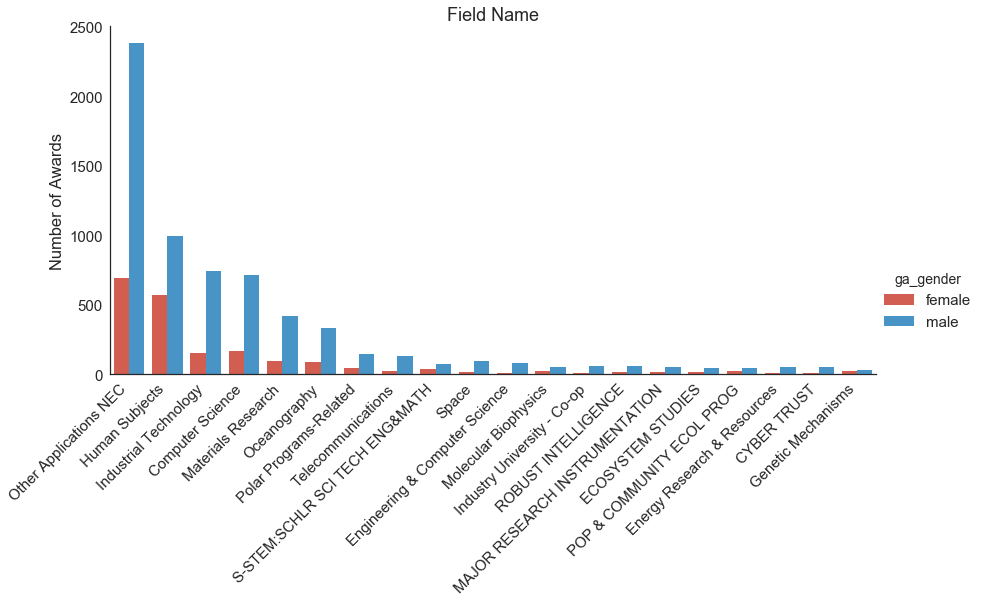

In [56]:
# plot disciplines color coded by Gender
color_code = [ "#e74c3c", "#3498db"]
filter = grants_df['StateCode'].isin(top_stats[:20])

plot = sns.factorplot(x='field_name', y='Counts', hue='ga_gender', kind='bar',\
                      data=grants_df, order=top_flds[:20], palette=sns.color_palette(color_code),\
                      estimator=sum, size=6, aspect=2)
plot.set_xticklabels(rotation=45, horizontalalignment='right');
xlabel(' ')
title('Field Name')
ylabel('Number of Awards')
savefig('field_gender_award_number.png', bbox_inches='tight')

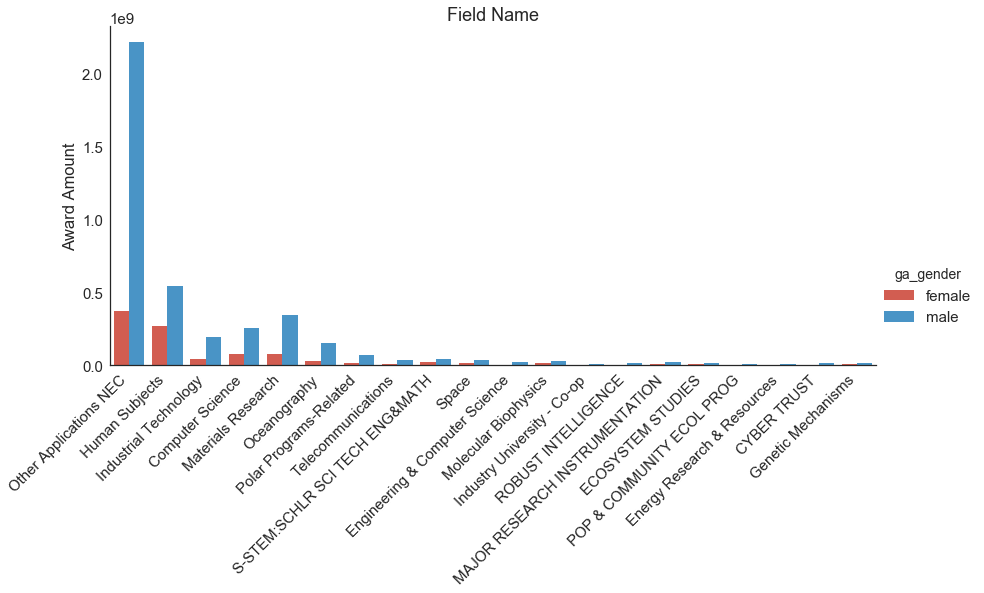

In [57]:
# plot disciplines color coded by Gender
color_code = [ "#e74c3c", "#3498db"]
filter = grants_df['StateCode'].isin(top_stats[:20])

plot = sns.factorplot(x='field_name', y='AwardAmount', hue='ga_gender', kind='bar',\
                      data=grants_df, order=top_flds[:20], palette=sns.color_palette(color_code),\
                      estimator=sum, size=6, aspect=2, ci=None)
ax.set_yscale('log')
plot.set_xticklabels(rotation=45, horizontalalignment='right');
savefig('field_gender.png', bbox_inches='tight')
xlabel(' ')
title('Field Name')
ylabel('Award Amount');
savefig('field_gender_award_amount.png', bbox_inches='tight')